# **Algoritmo regresivo en criptomoneda *Dogecoin* para analisis predictivo.**
Análisis de series de tiempo con redes de perceptrones multicapa

>_**Autor:** Nelson David Camacho Ovalle_

>_Universidad Nacional de Colombia: Facultad de Ingienería_
___

# **1. Entendimiento del negocio.**

La criptomoneda **Dogecoin** surgió en 2013 como una broma. Fue creada por Jackson Palmer y Billy Markus para satirizar el crecimiento de las criptomonedas alternativas, convirtiendo el meme de internet doge en una criptomoneda. Aunque nació como una broma, ha tenido cierta recepción en las redes sociales y su popularidad se ha disparado. Pero principalmente lo que llegó a destacar esta criptomoneda en el ultimo año se debe a el emprendedor **Elon Musk**, quien bajo su influencia, resalta esta criptomoneda en Twiter y debido a sus publicaciones el valor del Dogecoin se ha multiplicado considerablemente al punto de llamar la atención de personas que quieren invertir en la moneda mientras esta en auge para recibir ganancias a futuro, en vista que se estima que esta moneda pueda tener un potencial como la moneda BitCoin.

Lo anteriormente mencionado, nos sugiere la necesidad de hacer un análisis histórico de la moneda que nos permita observar la volatilidad de la divisa y simultáneamente realizar un análisis predictivo con el fin de aproximar a las personas al conocimiento, ya sea del aumento o baja del valor de esta moneda en los siguientes días con la finalidad de invertir de manera sensata.

<img src="https://a57.foxnews.com/static.foxbusiness.com/foxbusiness.com/content/uploads/2021/04/0/0/Elon-Musk-Dogecoin-2.jpg?ve=1&tl=1g" alt="Dogecoin y Elon Musk" width="800" height="450">

Por lo siguiente, los objetivos de este proyecto son:




### **Objetivo del proyecto**

- Realizar una visualización general de los datos.
- Realizar un algoritmo regresivo que permita evaluar y predecir el valor de la moneda y conocer la tendencia de este valor. 
- Realizar un análisis histórico de la moneda que provea información de interés.



## **Metodologia**

CRISP-DM

<img src="https://www.section.io/engineering-education/data-mining-using-crisp-dm-methodology/crisp-dm-framework.png" alt="Crisp-DM" width="640" height="380">

**NOTA**: Ejecutar este notebook en un entorno compatible con Plotly ya que todas las graficas utilizadas en este proyecto son interectivas.

# **2. Datos**
___


## **2.1. Dependencias**
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en el proyecto
___

In [1]:
# Librerias

#Scikit-learn 
import sklearn

# NumPy, Pandas, Matplotlib y Seaborn.
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

# Configuraciones 

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (9, 7)
plt.style.use('seaborn-dark')

!pip install -U plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px

Requirement already up-to-date: plotly in n:\aplicaciones\anaconda\lib\site-packages (4.14.3)


In [2]:
# Partición de series de tiempo

def temporalSplit(series, p):

  series_train = series[:round(len(series)*(1-p))]
  series_test = series[round(len(series)*(1-p)):]
  
  return series_train, series_test

In [3]:
# Funcion de validación cruzada para series de tiempo usando **sliding window** 

def slidingTime(ts, window_size=1):

  n = ts.shape[0] - window_size  
  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, ts.shape[0]):   
    y[i - window_size] = ts[i]
    X[i- window_size, 0:window_size] = np.array(ts[i - window_size:i])
    
  return X, y

In [4]:
# Predictor del siguiente valor

def predictNewData(model, window):
    pred = model.predict(window)
    return pred 

In [5]:
# Predictor siguientes n valores

def predictNData(model, window, n):

  pred = []
  win = window.reshape(1,-1)

  for i in range(n):
    
    pred = np.append(pred, predictNewData(model, win))
    win = np.roll(win, -1)
    win[0,-1] = pred[-1]
  
  return pred

In [6]:
# Grafica de predicción en series de tiempo

def plotPrediction(params, ys, df, test_date_index): 

  train_data = df.loc[:test_date_index[0]]
  _y_test, _y_forward, _y_last = ys

  fig = go.Figure(layout = dict(title = f'<b>Grafico de divisa DOGE-USD Enero/Mayo con predictores</b> <br> {params}', width = 1200, height = 600, template='plotly_dark'))
  
  fig.add_trace(go.Scatter(x = train_data.index,y = train_data.values.reshape(len(train_data.values),), mode = 'lines', name = 'Valores de entrenamiento y pruebas'))

  fig.add_trace(go.Scatter(x = test_date_index, y = _y_test, mode='lines', name='Valores reales (y)'))

  fig.add_trace(go.Scatter(x = test_date_index, y = _y_forward, mode = 'lines', name = 'Valores predichos a partir de datos reales'))

  fig.add_trace(go.Scatter(x = test_date_index, y = _y_last,mode='lines',name='Valores predichos a partir de datos predichos'))

  fig.show()

In [7]:
# Grafica general de predicción

from plotly.subplots import make_subplots

def plotGeneral(Full, PreReal, PrePre, Title='Grafica General'): 

  fig = make_subplots(rows=1, cols=3)

  fig.add_trace(go.Scatter(x= Full.index, y = Full.values.reshape(len(Full),), mode='lines', name='Valores reales (y)'), row=1, col=1)

  fig.add_trace(go.Scatter(x= Full.index, y = PreReal, mode = 'lines', name = 'Valores predichos a partir de datos reales'), row=1, col=2)

  fig.add_trace(go.Scatter(x= Full.index, y = PrePre ,mode='lines',name='Valores predichos a partir de datos predichos'), row=1, col=3)

  fig.update_layout(title = Title, width = 2000, height = 600, template='plotly_dark')

  fig.show()

## **2.2 Conjunto de datos (Dataset)**
El dataset a usar es un historico del valor de la criptomoneda Dogecoin de la pagina *coindesk* desde inicio del año 2021 hasta el 7 de Mayo del 2021 (Actual)

> *Info: https://www.coindesk.com/price/dogecoin*


In [8]:
# Dataset

Cdf = pd.read_csv("https://drive.google.com/u/2/uc?id=1DgaaQepSg-jm1MPzhKAorSv4hqqxIxj3&export=download")
Cdf

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,DOGE,2021-01-01,0.005405,0.004665,0.005516,0.004621
1,DOGE,2021-01-02,0.011427,0.005681,0.013892,0.005550
2,DOGE,2021-01-03,0.010046,0.010450,0.013907,0.009240
3,DOGE,2021-01-04,0.009630,0.009694,0.011450,0.007654
4,DOGE,2021-01-05,0.009730,0.009779,0.010279,0.008835
...,...,...,...,...,...,...
122,DOGE,2021-05-03,0.436416,0.374616,0.447835,0.374383
123,DOGE,2021-05-04,0.542511,0.441759,0.611135,0.404327
124,DOGE,2021-05-05,0.641605,0.539316,0.696495,0.521011
125,DOGE,2021-05-06,0.586173,0.653902,0.664794,0.541252


In [9]:
# Renombrar columnas (Ingles a Español)
Cdf.rename(columns={'Currency':'Moneda','Date':'Fecha','Closing Price (USD)':'Precio de cierre (USD)','24h Open (USD)':'24h Entrada (USD)','24h High (USD)':'24h Max (USD)','24h Low (USD)':'24h Min (USD)'},inplace=True)
Cdf.columns

Index(['Moneda', 'Fecha', 'Precio de cierre (USD)', '24h Entrada (USD)',
       '24h Max (USD)', '24h Min (USD)'],
      dtype='object')

## **2.3. Descripción  y preparación de los datos**
___
Con el fin de proseguir, es necesario entender que corresponde cada variable con su descripción y así realizar el proceso de la preparación de los datos.

| Variable          | Descripción                                          | 
| :---------------- | :---------------------------------------------------: | 
| Moneda            | Nombe de la divisa, en este caso *DOGE* |
| Fecha             | Fecha de la muestra |
| Precio de cierre (USD)    | Precio en el que se concluye el valor de la divisa al final del dia. |
| 24h Entrada (USD) | Precio de entrada en el dia.                     |
| 24h Max (USD)     | Precio mas alto en el que la divisa tomo en el transcurso del dia. |
| 24h Min (USD)     | Precio mas bajo en el que la divisa tomo en el transcurso del dia. |


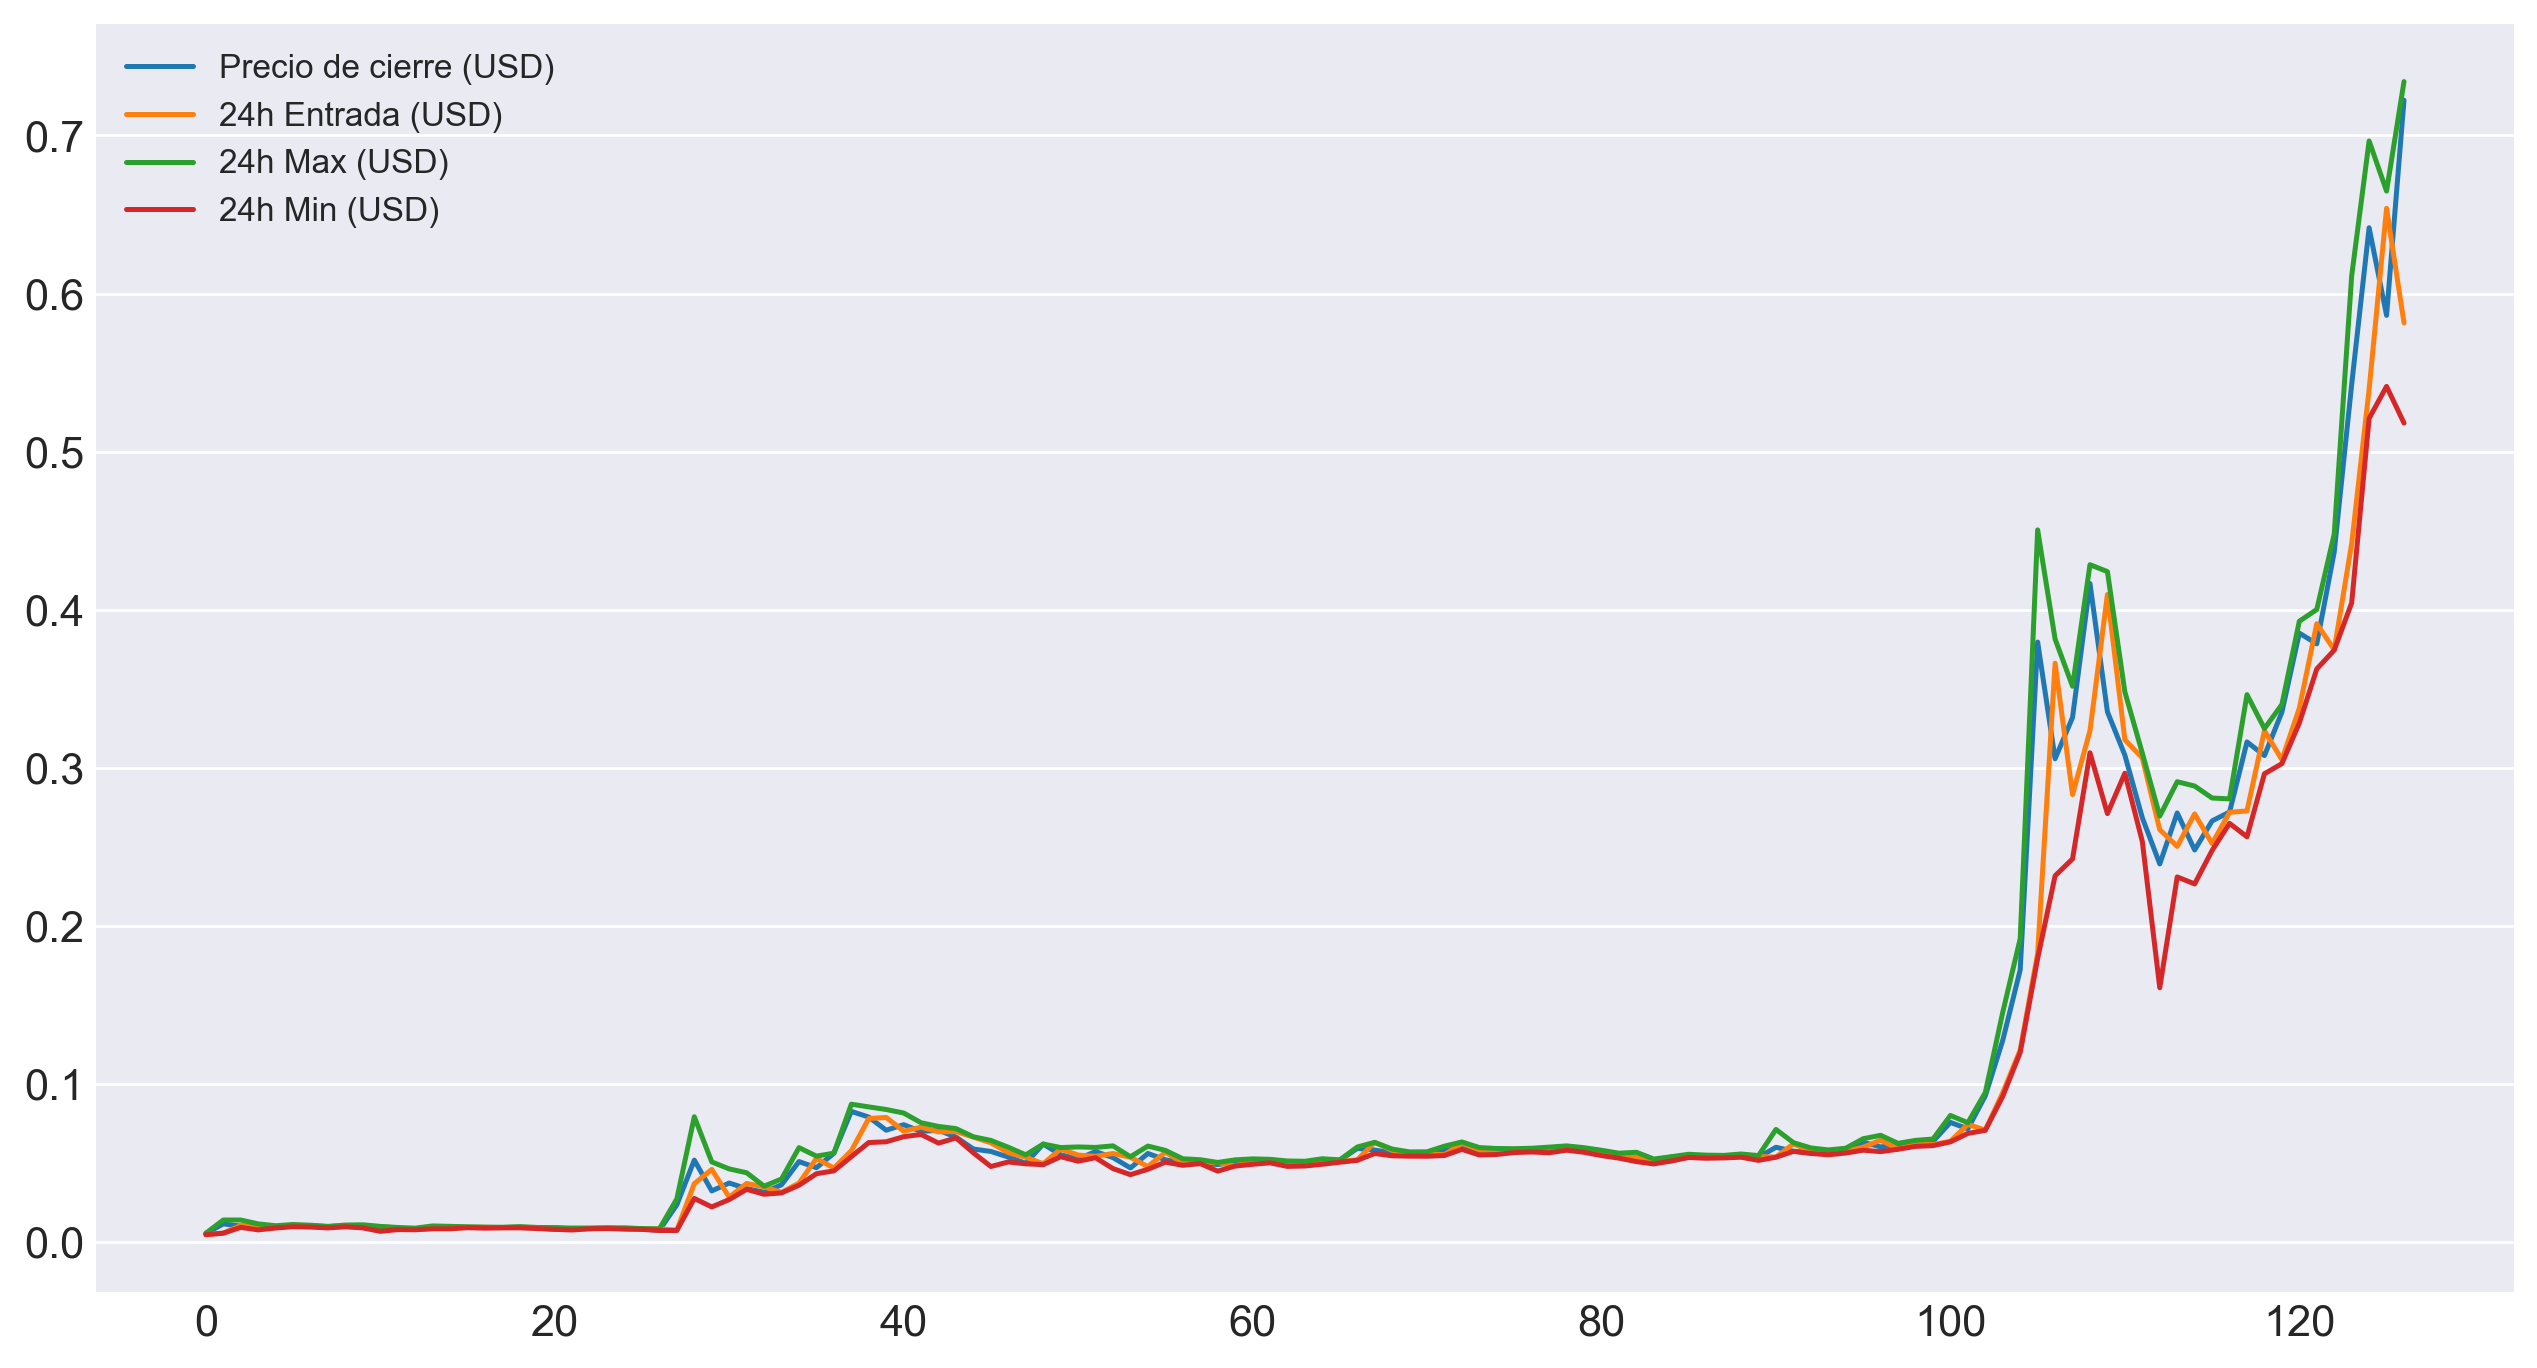

In [10]:
Cdf.plot(figsize = (13, 7),fontsize = 13).yaxis.grid()

En el caso que queremos predecir el valor de la divisa al siguiente dato, nos interesa saber cual es su precio al finalizar, dando una estimación de como estará en el transcurso del día. Por lo siguiente, la variable de interés a predecir es el **Precio de cierre (USD)** y la **Fecha** correspondiente.


In [11]:
Dogedf = pd.DataFrame(data = np.array(Cdf['Precio de cierre (USD)']), index=Cdf['Fecha'], columns={'Precio de cierre (USD)'})
Dogedf

,Precio de cierre (USD)
Fecha,
2021-01-01,0.005405
2021-01-02,0.011427
2021-01-03,0.010046
2021-01-04,0.009630
2021-01-05,0.009730
...,...
2021-05-03,0.436416
2021-05-04,0.542511
2021-05-05,0.641605


In [12]:
fig = px.line(Dogedf, y="Precio de cierre (USD)", title='Grafico de divisa DOGE-USD Enero/Mayo', width=1200, height=700, template='plotly_dark')
fig.show()


**IMPORTANTE** Visualizando la grafica, más del 70% de los datos representan valores pequeños y sin mucha variación. Esta es una limitación del dataset para un problema reciente. Por lo anterior, se utilizará mas del 80% de datos de entrenamiento, por lo que el momento el modelo creado en este notebook será de exploración y se planteará a futuro una mejora de este.

# **3. Modelamiento**

Se realizará el modelamiento de los datos (Entrenamiento y prueba) y visualización de corrimiento de ventana para en los casos de entrenamiento usando **TimeSeriesSplit**

Para preparar el modelado autoregresivo describimos cuales datos se utilizarian para la ventana (Azul) y cual seria su saluda correspondiendo al valor actual.

Las *features* serán las $k$ observaciones previas, que corresponden a una **ventana** de tamaño $k$. 

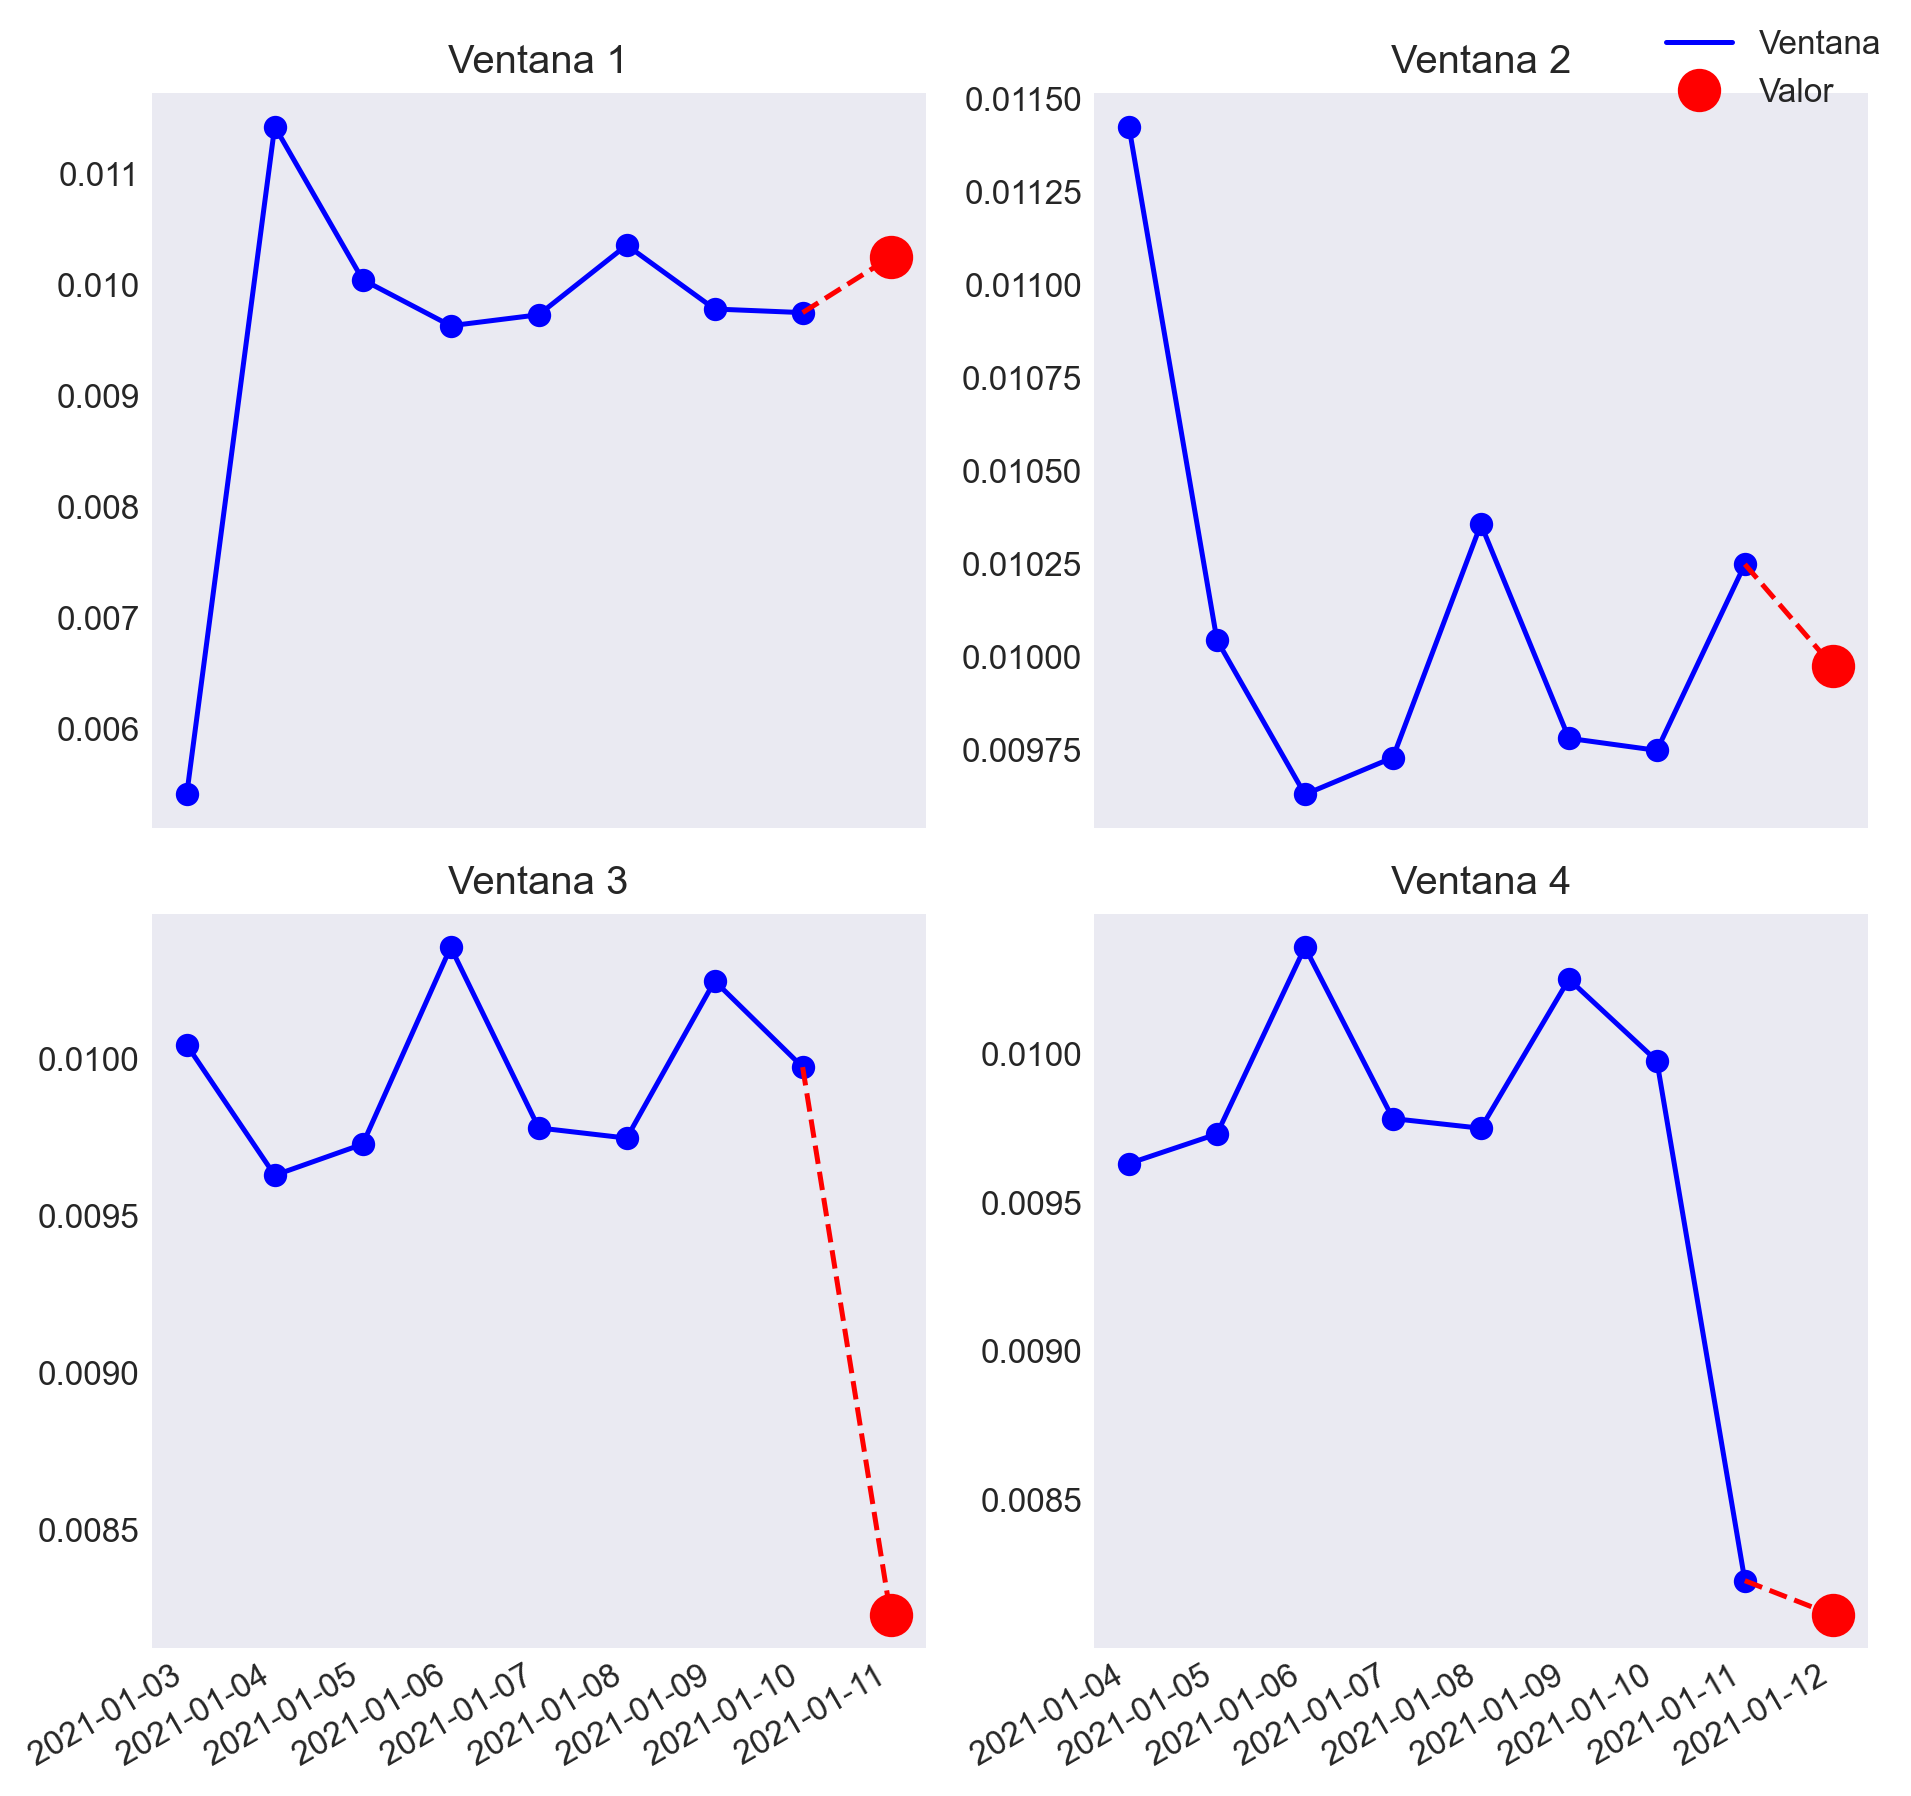

In [13]:
n = 5  # Numero de graficas
k = 9  #Numero de observaciones por ventana

fig, axes = plt.subplots(nrows = n//2, ncols= 2,  figsize = (8, 1.5*n), dpi = 120)

for i, ax in enumerate(axes.flat):  
  data =  Dogedf.iloc[i: i + k]
  ax.set_title(f'Ventana {i + 1}')
  ax.plot(data.index[:-1], data.values[:-1], 'b')
  ax.plot(data.index[-1], data.values[-1], 'ro', ms = 12)  
  ax.plot(data.index[:-1], data.values[:-1], 'bo')
  ax.plot(data.index[-2:], data.values[-2:], 'r--')
  fig.autofmt_xdate()
fig.tight_layout()

fig.legend(['Ventana', 'Valor']);

Como el tamaño del dataset es pequeño (127 muestras) para nuestro modelo utilizaremos **9 observaciones**

In [14]:
k = 9

Para la preparación de los datos se separan los **datos de entrenamiento y prueba** para preparar el modelo predictorio.

In [15]:
DogeTrain, DogeTest = temporalSplit(Dogedf, p=0.15) # Se utilizarán 85% de los datos para el entrenamiento y 15% de los datos para la prueba
DogeTrain.shape, DogeTest.shape

((108, 1), (19, 1))

In [16]:
# Fechas representativas
DogeTrain.index[-1], DogeTest.index[0] #Fecha de finalización del dataset de entrenamiento y fecha de inicio del dataset de prueba

('2021-04-18', '2021-04-19')

## **3.1 Diseño de la experimentación (Validación cruzada)**

Como se mencionó previamente se utilizará el corrimiento de ventana para series de tiempo **TimeSeriesSplit**.Por lo que previo a implementar en un modelo regresivo se visualizará los datos por pliegue y en que rango de valores se encuentran. Tener en cuenta que **TimeSeriesSplit** utiliza **forward chaining** para la validación cruzada.

In [17]:
X_train, y_train = slidingTime(DogeTrain.values.reshape(len(DogeTrain),), window_size=k) 
X_test, y_test = slidingTime(DogeTest.values.reshape(len(DogeTest),), window_size=k) 

In [18]:
from sklearn.model_selection import TimeSeriesSplit

# Definimos el número de splits para realizar cross-validation
tsp = TimeSeriesSplit(n_splits=5)

In [19]:
for i, (train_index, test_index) in enumerate(tsp.split(X_train, y_train)):

  print(f'-------------------- Pliegue {i + 1} --------------------')
  print("\tPartición de entrenamiento")
  print(f'\t\tTamaño de la partición: {train_index.shape}')
  print(f'\t\tRango de valores: {train_index[0]}-{train_index[-1]}\n')

  print("\tPartición de validación")
  print(f'\t\tTamaño de la partición: {test_index.shape}')
  print(f'\t\tRango de valores: {test_index[0]}-{test_index[-1]}\n')  

-------------------- Pliegue 1 --------------------
	Partición de entrenamiento
		Tamaño de la partición: (19,)
		Rango de valores: 0-18

	Partición de validación
		Tamaño de la partición: (16,)
		Rango de valores: 19-34

-------------------- Pliegue 2 --------------------
	Partición de entrenamiento
		Tamaño de la partición: (35,)
		Rango de valores: 0-34

	Partición de validación
		Tamaño de la partición: (16,)
		Rango de valores: 35-50

-------------------- Pliegue 3 --------------------
	Partición de entrenamiento
		Tamaño de la partición: (51,)
		Rango de valores: 0-50

	Partición de validación
		Tamaño de la partición: (16,)
		Rango de valores: 51-66

-------------------- Pliegue 4 --------------------
	Partición de entrenamiento
		Tamaño de la partición: (67,)
		Rango de valores: 0-66

	Partición de validación
		Tamaño de la partición: (16,)
		Rango de valores: 67-82

-------------------- Pliegue 5 --------------------
	Partición de entrenamiento
		Tamaño de la partición: (83,)


## **3.2. Selección y construcción del modelo**

Para este problema (Predicción en series de tiempo) es necesario un modelo de regresión, pero como se utilizan datos de validación previos para comprobar y entrenar, es un problema supervisado de regresión.

Por lo que se utilizará el modelo de redes neuronales (Regresor de perceptron multicapa) **MLPRegresor** y para la valiación cruzada se utilizará **TimeSeriesSplit** y **GridSearchCV** para la exploración de hiperparámetros que aporten al desarrollo del modelo.

In [20]:
# Perceptron multicapa
# Grid Search para el modelo MLPRegressor

from sklearn.neural_network import MLPRegressor 
from sklearn.model_selection import GridSearchCV

params = {
      'max_iter': [1000, 2000, 3000], # Numero maximo de iteraciones
      'random_state': [12, 123, 1234, 12345],   # Ya que el regresor comienza desde un valor aleatorio, le damos unas semillas para que los datos sean replicables y que como hiperparametro se busque el mejor.
      'solver': ['lbfgs', 'sgd', 'adam'],  #Algoritmos de aprendizaje
      'hidden_layer_sizes' : [(10,), (20,), (40,), (80,), (100,) ], # Arquitecturas de redes
      'activation' : ['logistic', 'tanh', 'relu']   # Funciones de activación.
 }

tsp = TimeSeriesSplit(n_splits = 5)

# Como es una exploración de varios hiperparametros, el ajuste del modelo puede demorarse unos minutos
gsearch = GridSearchCV(estimator = MLPRegressor(), cv = tsp, param_grid = params, verbose = 3)

gsearch.fit(X_train, y_train)

elu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=lbfgs;, score=-40.191 total time=   0.0s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=lbfgs;, score=0.335 total time=   0.0s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=lbfgs;, score=-0.250 total time=   0.0s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=lbfgs;, score=0.337 total time=   0.0s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=sgd;, score=-0.597 total time=   0.0s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=sgd;, score=-116.230 total time=   0.0s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), max_iter=3000, random_state=12345, solver=sgd;, score=-46.707 total time=   0.0s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), max_ite

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (20,), (40,), (80,),
                                                (100,)],
                         'max_iter': [1000, 2000, 3000],
                         'random_state': [12, 123, 1234, 12345],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=3)

In [21]:
# Mejor estimador obtenido por la busqueda de hiperparametros

gsearch.best_estimator_

MLPRegressor(activation='tanh', hidden_layer_sizes=(10,), max_iter=1000,
             random_state=1234, solver='lbfgs')

## **3.3. Visualización de datos** 
Visualización interactiva de datos reales, los valores predichos a partir de los datos reales y los datos predichos a partir de los datos predichos.

In [22]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = DogeTest.index[k:]

In [23]:
plotPrediction(gsearch.best_params_, (y_test, y_forward, y_last), Dogedf ,test_date_index)

**Metricas de evaluación del modelo obtenido a partir de datos predichos y datos reales**

In [24]:
# Datos predichos a partir de datos predichos.

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error 

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_last):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_last):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_last):.4f}")

Test Mean Squared Error: 	0.0422
Test Mean Absolute Error: 	0.1666
Test Mean squared log error: 	0.0197


In [25]:
# Datos predichos a partir de datos reales.

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_forward):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_forward):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_forward):.4f}")

Test Mean Squared Error: 	0.0039
Test Mean Absolute Error: 	0.0483
Test Mean squared log error: 	0.0016


Se puede visualizar que los datos predichos a partir de datos reales corresponden muy bien con los datos reales. Los datos predichos a partir de los mismos no corresponden a la misma magnitud de valores, no obstante podrian determinar si los datos predichos pueden subir o bajar sin tener en cuenta el dato predicho

**Importante**: De igual manera, como se menciono al prinicpio del notebook. La cantidad de datos de prueba fueron muy pocos y estos resultados pueden variar.

In [26]:
DogeFull = Dogedf
DogePreReal = np.append(DogeFull.iloc[0:len(DogeFull)-len(np.array(y_last))], np.array(y_forward))
DogePrePre = np.append(DogeFull.iloc[0:len(DogeFull)-len(np.array(y_last))], np.array(y_last))

In [27]:
## Grafico predicho con graficas independientes

plotGeneral(DogeFull, DogePreReal, DogePrePre, 'Grafico de divisa DOGE-USD Enero/Mayo completa')

## **3.4. Funciones de predicción**

A Partir del modelo implementado y entrenado, es necesario una función para obtener el resultado de una predicción a partir de datos reales o de predicción a partir de los mismos con el fin de que la persona interesada en invertir de esta criptomodena obtenga resultados. 

In [28]:
#Ultimos 9 dias del dataset (Ventana de 9 datos segun como se entreno)

last9Days = np.array(DogeFull[-9:]).T
last9Days

array([[0.30770208, 0.33514727, 0.38515967, 0.37840286, 0.4364163 ,
        0.54251097, 0.6416045 , 0.58617341, 0.72232048]])

In [29]:
# Predecir nuevo dato a partir de datos reales
# Predecir valor de la divisa para la fecha siguiente al dataset (8 de Mayo del 2021)

NewDataPred = predictNewData(gsearch,last9Days)
NewDataPred 

array([0.68290184])

In [30]:
# Predecir n datos  (La siguiente semana a la fecha actual (8 De Mayo - 15 de Mayo))
#n = 7 dias

n = 7
NData = predictNData(gsearch, last9Days, n)
NData

array([0.68290184, 0.60577891, 0.63932175, 0.59737864, 0.49483034,
       0.50928448, 0.46219681])

# **4. Analisis histórico**

A Partir de los datos predichos y los datos reales, se realizará un análisis que completará el resultado obtenido y proverá información de la tendencia al lector acerca de la criptomoneda.
___

## **4.1. Porcentaje de cambio**

El porcentaje de cambio determina como cambia el valor de la divisa actual con respecto a su anterior valor y de igual manera, determina si este valor subio o bajo en porcentaje. 

El porcentaje de cambio se determina como:


$$
PDC\:\left(\%\right)=\:100\cdot \frac{Data\left[i\right]\:-\:Data\left[i-1\right]}{Data\left[i-1\right]}
$$


In [31]:
def PorcentajeDeCambio(Data, Data_m_1):
    rz = 100* (Data - Data_m_1) / Data_m_1
    return rz

**Ejemplo:** Utilizando el dato predicho del 8 de Mayo con respecto a su anterior porcentaje de cambio es:

In [32]:
print(PorcentajeDeCambio(NewDataPred, np.array(DogeFull)[-1]))

[-5.45722311]


En conclusión: el resultado del 8 de Mayo bajo con un $5.45%$ en relación con el dato anterior.

$$\left(Lastdata\right)+\left(Lastdata\cdot PDC\right)\:=\:DatoPredict$$

$$\left(0.72232048\right)+\left(0.72232048\cdot -0.0545722311\right)\:=\:0.68290184$$

## **4.2. Derivada**

Determina la taza de cambio o pendiente para observar que tanto ha fluctuado o que tanto a cambiado el valor de la moneda.

La derivada se determina como:

$$
\frac{d}{dk}\:=\:\frac{Data\left[k\right]\:-\:Data\left[k-1\right]}{k\:-\:\left(k-1\right)}
$$

In [33]:
def Derivada(Data, Data_m_1, idx, idx_m_1):
    der = (Data - Data_m_1) / (idx - idx_m_1)
    return der

**Ejemplo:** Utilizando el dato predicho del 8 de Mayo con respecto a su anterior su derivada o su pendiente es:


In [34]:
print(Derivada(NewDataPred, np.array(DogeFull)[-1], 2, 1))

[-0.03941864]


En conclusión: El resultado del 8 de Mayo cambio con una magnitud de -0.03 con respecto al anterior.

## **4.3. Grafica PDC de los datos reales y predichos**

En relación con el porcentaje de cambio, se puede observar que tanto a cambiado con respecto a un dato anterior y visualizar de manera histórica que tanto han cambiado un dato nuevo con respecto al anterior.

___

In [35]:
# Extrapolación del PDC al uso de un vector 

def PorcentajeDeCambioGeneral(Data):

    ArrayD = np.array(Data)

    PDC = np.zeros(len(ArrayD))
    for i in range(1, len(ArrayD)):
        PDC[i] = PorcentajeDeCambio(ArrayD[i], ArrayD[i-1])

    return PDC

In [36]:
PDCFull = pd.DataFrame(PorcentajeDeCambioGeneral(DogeFull), index= DogeFull.index)
PDCPreReal = PorcentajeDeCambioGeneral(DogePreReal)
PDCPrePre = PorcentajeDeCambioGeneral(DogePrePre)

In [37]:
plotGeneral(PDCFull, PDCPreReal, PDCPrePre, 'Grafico de porcentaje de cambio(%) divisa DOGE-USD ')

En esta grafica podemos visualizar que tanto cambio la divisa. Por ejemplo: En **Abril 16 del 2021** la divisa aumento un 120% con respecto al valor de cierre de **Abril 15 del 2021**. Es decir, aumento aproximadamente 2 veces.

## **4.5. Grafica de Derivada de los datos reales y predichos**

Usando la derivada podemos visualizar en que factor los datos cambian con respecto a su anterior. Observando la fluctación de la moneda.
___




In [38]:
# Extrapolación de la derivada al uso de vectores

def DerivadaGeneral(Data):

    ArrayD = np.array(Data)

    DER = np.zeros(len(ArrayD))
    for i in range(1, len(ArrayD)):
        DER[i] = Derivada(ArrayD[i], ArrayD[i-1], i, i-1)

    return DER

In [39]:
DERFull = pd.DataFrame(DerivadaGeneral(DogeFull), index= DogeFull.index)
DERPreReal = DerivadaGeneral(DogePreReal)
DERPrePre = DerivadaGeneral(DogePrePre)

In [40]:
plotGeneral(DERFull, DERPreReal, DERPrePre, 'Grafico de derivada divisa DOGE-USD ')


En la grafica podemos observar que si el dato se mantiene cercano a cero, el valor de la moneda no varia mucho, se podria decir que permanece constante en un rango pequeño. 

Si el valor es alto, quiere decir que se aumento en magnitud en relación con el valor de la divisa. Como se visualizo anteriormente el **16 de Abril** aumento considerablemente siendo una fecha de importancia para el crecimiento de la divisa.

## **4.6. Grafica SIGNO los de datos reales y predichos**

Una de las propiedades del PDC es que en el mismo porcentaje determina si aumento (Signo positivo), disminuyó (Signo negativo) o permanece constante (Igual a cero). 

Utilizando la función signo de la librería *Numpy* sobre el PDC histórico podemos observar que tanto ha subido, bajado o en neutro el valor con respecto a su anterior.
___


In [41]:
SIGNFull = pd.DataFrame(np.sign(PorcentajeDeCambioGeneral(DogeFull)), index= DogeFull.index)
SIGNPreReal = np.sign(PorcentajeDeCambioGeneral(DogePreReal))
SIGNPrePre = np.sign(PorcentajeDeCambioGeneral(DogePrePre))

plotGeneral(SIGNFull, SIGNPreReal, SIGNPrePre, 'Grafico signo de cambio divisa DOGE-USD (1- sube, -1 baja, 0 no cambia)')

En estas graficas podemos determinar si la divisa tiene un comportamiento oscilante. Es decir, que se mantiene subiendo y bajando. Es decir, que no es estable o que es **volatil**.

Teniendo en cuenta que la *volativilidad* de la divisa es la variación que sufre el precio de un activo.

De igual, con la grafica Signo, podemos determinar cuantas veces a bajado, subido o a permanecido neutro de manera historica, contando las ocurrencias de sus datos.

In [42]:
Sf = np.unique(SIGNFull, return_counts=True)

print('Estabilidad de la divisa')
print('-----------------------------------')
print(f'La divisa a bajado un total de {Sf[1][0]} veces')
print(f'La divisa a permanecido estable un total de {Sf[1][1]} veces')
print(f'La divisa a bajado un total de {Sf[1][2]} veces')

Estabilidad de la divisa
-----------------------------------
La divisa a bajado un total de 66 veces
La divisa a permanecido estable un total de 1 veces
La divisa a bajado un total de 60 veces


En **conclusión** a el anterior resultado, la criptomoneda Dogecoin *DOGE* de manera historica ha bajado mas veces su valor, de lo que sube o se mantiene neutra.

# **5. Resultados**

En relación con lo anterior, se presenta los resulados utilizando las funciones de predicción *(predictNewData, predictNData)*, PDC (Porcentaje de cambio) y la función signo con el fin de tener un resultado más completo y visualmente interpretable al usuario.

___


In [43]:
# Resultado a partir de los datos reales

def ResultadoPredictivo(Window, round=4):
    msg = ''
    pred = np.round(np.asscalar(predictNewData(gsearch,Window)),round)
    PDC = np.round(np.asscalar(PorcentajeDeCambio(pred, Window.flat[-1])),round)
    SIGNpred = np.sign(PDC)

    if(SIGNpred == 1):
        msg = f"\033[1;32;48m ↑ %{PDC} Subio, Precio predecido (USD): {pred}"
    elif(SIGNpred == -1):
        msg = f"\033[1;31;48m ↓ %{PDC} Bajo, Precio predecido (USD): {pred}" 
    else:
        msg = f"\033[1;30;48m → %{PDC} neutro, Precio predecido (USD): {pred}"

    return pred, PDC, SIGNpred, msg

In [44]:
# N Reusltados a partir de datos predichos

def ResultadoNPredictivo(Window, n, round=4):

    pred = np.round(predictNData(gsearch,Window,n),round)
    
    msg = []
    PDC = np.zeros(len(pred))
    SIGNPred = np.zeros(len(pred))

    _,b,c,d = ResultadoPredictivo(Window, round=round)

    PDC[0] = b
    SIGNPred[0] = c
    msg.append(d)

    for i in range(1,len(pred)):
    
        PDC[i] = np.round(np.asscalar(PorcentajeDeCambio(pred[i], pred[i-1])),round)
        SIGNPred[i] = np.sign(PDC[i])

        if(SIGNPred[i] == 1):
            msg = np.append(msg, f"\033[1;32;48m ↑ %{PDC[i]} Subio, Precio predecido (USD): {pred[i]}")
        elif(SIGNPred[i] == -1):
            msg = np.append(msg,f"\033[1;31;48m ↓ %{PDC[i]} Bajo, Precio predecido (USD): {pred[i]}")
        else:
            msg = np.append(msg,f"\033[1;30;48m → %{PDC[i]} neutro, Precio predecido (USD): {pred[i]}")

   
    return pred, PDC, SIGNPred, msg
  

In [45]:
# Ultimos 9 dias como ventana
last9Days = np.array(DogeFull[-9:]).T

In [46]:
_,_,_,msg = ResultadoPredictivo(last9Days)
print(msg)

 ↓ %-5.4575 Bajo, Precio predecido (USD): 0.6829


In [47]:
# Resultado para los siguientes n dias
n = 7 #Siguientes 7 dias (Siguiente semana)

_, _, _, msg = ResultadoNPredictivo(last9Days, n)

for i in range(0,len(msg)):
    print(msg[i])

 ↓ %-5.4575 Bajo, Precio predecido (USD): 0.6829
 ↓ %-11.2901 Bajo, Precio predecido (USD): 0.6058
 ↑ %5.5299 Subio, Precio predecido (USD): 0.6393
 ↓ %-6.554 Bajo, Precio predecido (USD): 0.5974
 ↓ %-17.1744 Bajo, Precio predecido (USD): 0.4948
 ↑ %2.9305 Subio, Precio predecido (USD): 0.5093
 ↓ %-9.248 Bajo, Precio predecido (USD): 0.4622


# **6. Conclusiones**
___

A partir de los datos anteriores y los objetivos planteados en el desarrollo del proyecto, se concluye que:

- El Modelo de perceptron multicapa (Regresor) otorga unos muy buenos resultados como predictor. Sin embargo, en casos que requieran de un análisis más exhaustivo es necesario uso de otros metodos como LSTM y la inclusión de factores sociales que puedan variar el flujo de la divisa como publicaciones en las redes sociales (Twitter) que puedan aportar al desarrollo de un modelo predictivo más completo.
https://www.researchgate.net/publication/304812769_Prediccion_del_Impacto_en_mensajes_de_Twitter_mediante_redes_neuronales

- La divisa Dogecoin aunque esta en auge y tiene bastante popiularidad, es muy volatíl. De acuerdo con la tendencia histórica su valor baja más de lo que puede subir y es muy dependiente de factores sociales. Si se desea invertir en esta divisa, se sugiere conocer sobre las ganancias o pérdidas que puede implicar invertir ya que supone en gran nivel de riesgo.

- El modelo regresor puede dar un valor aproximado del precio predicho, pero el potencial de este recae en si el valor baja o sube, con el fin de determinar una desición de inversión no en relación en su precio sino de su potencial cambio. 


# **7. Creditos**
___

* Nelson David Camacho Ovalle
* **Profesor:** [Fabio Augusto González](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:** 
  * Juan Lara



**Universidad Nacional de Colombia** - *Facultad de Ingeniería*